# Importing the Libraries

In [1]:
import numpy as anp
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation,Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras import optimizers

# Importing DataSet

In [2]:
train_df = pd.read_csv('train.csv', dtype = str)
test_df = pd.read_csv('test.csv', dtype = str)

In [3]:
train_df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.0,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.0,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.0,1,8849.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Image_path         1399 non-null   object
 1   Insurance_company  1399 non-null   object
 2   Cost_of_vehicle    1310 non-null   object
 3   Min_coverage       1310 non-null   object
 4   Expiry_date        1399 non-null   object
 5   Max_coverage       1310 non-null   object
 6   Condition          1399 non-null   object
 7   Amount             1388 non-null   object
dtypes: object(8)
memory usage: 87.6+ KB


In [5]:
train_df.shape

(1399, 8)

In [6]:
test_df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage
0,img_4538519.jpg,B,23600,590.0,2025-04-12,5978.0
1,img_7766002.jpg,C,28300,707.5,2028-08-24,7153.0
2,img_4637390.jpg,AC,43700,1092.5,2023-11-28,11003.0
3,img_4516108.jpg,BB,46100,1152.5,2028-02-04,11603.0
4,img_4517008.jpg,BB,40700,1017.5,2022-01-03,10253.0


In [7]:
test_df.shape

(600, 6)

# Splitting the training data for using it with images data for the calculation of the condition column

In [8]:
train, test = train_test_split(train_df, test_size = 0.2, random_state = 42)

# Data Pre-processing
## Generating images for the Training set

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255., 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)


## Generating images for the testing set

In [10]:
test_datagen = ImageDataGenerator(rescale = 1./255.)

## Creating the Training set

In [11]:
training_set = train_datagen.flow_from_dataframe(dataframe = train,
                                              directory = "trainImages",
                                              x_col = 'Image_path', 
                                              y_col ='Condition',
                                              target_size = (200,200),
                                              batch_size = 256, 
                                              class_mode = 'binary', 
                                              shuffle = True)


Found 1119 validated image filenames belonging to 2 classes.


## Creating the Testing set

In [12]:
testing_set = test_datagen.flow_from_dataframe(directory = "testImages", 
                                            dataframe = test_df, 
                                            target_size = (200,200),
                                            x_col = 'Image_path', 
                                            y_col = None, 
                                            shuffle = False,
                                            batch_size = 256, 
                                            class_mode = None)

Found 600 validated image filenames.


## Usign the ResNet Model

In [13]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', 
                                              input_shape = (200,200,3),
                                              include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()   

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 102, 102, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

## Building the CNN

In [14]:
# Initialising the CNN

cnn = Sequential()

In [15]:
# Adding the ResNEt Model

cnn.add(base_model)

In [16]:
# Pooling

cnn.add(GlobalAveragePooling2D())

In [17]:
# Full Connection

cnn.add(Dense(10))

In [18]:
# Output Layer

cnn.add(Dense(units=1, activation='sigmoid'))

In [19]:
# Droupout Layer

cnn.add(Dropout(0.2))

In [20]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
Total params: 23,585,301
Trainable params: 20,501
Non-trainable params: 23,564,800
_________________________________________________________________


In [21]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [22]:
# Compiling the CNN

cnn.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [23]:
# Training the CNN on the Training set and evaluating it on the Test set

cnn.fit(training_set, epochs = 10)

Epoch 1/10
5/5 [==============================] - 64s 13s/step - loss: 3.4321 - accuracy: 0.7158
Epoch 2/10
5/5 [==============================] - 61s 12s/step - loss: 3.4918 - accuracy: 0.7319
Epoch 3/10
5/5 [==============================] - 76s 15s/step - loss: 3.2889 - accuracy: 0.7471
Epoch 4/10
5/5 [==============================] - 76s 15s/step - loss: 3.4260 - accuracy: 0.7560
Epoch 5/10
5/5 [==============================] - 63s 13s/step - loss: 3.4835 - accuracy: 0.7435
Epoch 6/10
5/5 [==============================] - 61s 12s/step - loss: 3.4091 - accuracy: 0.7462
Epoch 7/10
5/5 [==============================] - 64s 13s/step - loss: 3.0811 - accuracy: 0.7623
Epoch 8/10
5/5 [==============================] - 63s 13s/step - loss: 3.4081 - accuracy: 0.7525
Epoch 9/10
5/5 [==============================] - 64s 13s/step - loss: 3.3496 - accuracy: 0.7587
Epoch 10/10
5/5 [==============================] - 66s 13s/step - loss: 3.2166 - accuracy: 0.7587


In [24]:
cnn.evaluate(training_set)

5/5 [==============================] - 60s 12s/step - loss: 0.2231 - accuracy: 0.9223


[0.22313660383224487, 0.9222519993782043]

In [25]:
preds = (cnn.predict(testing_set)>0.5).astype("int32")

preds

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
    

### Output :
0 : Not Damaged and <br>
1: Damaged

In [26]:
test_df['Condition'] = pd.DataFrame(preds)

In [27]:
test_df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition
0,img_4538519.jpg,B,23600,590.0,2025-04-12,5978.0,1
1,img_7766002.jpg,C,28300,707.5,2028-08-24,7153.0,1
2,img_4637390.jpg,AC,43700,1092.5,2023-11-28,11003.0,1
3,img_4516108.jpg,BB,46100,1152.5,2028-02-04,11603.0,1
4,img_4517008.jpg,BB,40700,1017.5,2022-01-03,10253.0,1


In [28]:
test_df.shape

(600, 7)

# EDA of the data

In [29]:
train_df.isnull().sum()

Image_path            0
Insurance_company     0
Cost_of_vehicle      89
Min_coverage         89
Expiry_date           0
Max_coverage         89
Condition             0
Amount               11
dtype: int64

<AxesSubplot:>

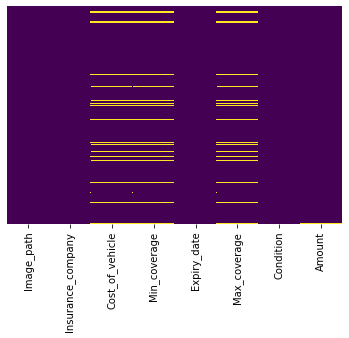

In [30]:
sns.heatmap(train_df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [31]:
test_df.isnull().sum()

Image_path           0
Insurance_company    0
Cost_of_vehicle      0
Min_coverage         0
Expiry_date          0
Max_coverage         0
Condition            0
dtype: int64

<AxesSubplot:>

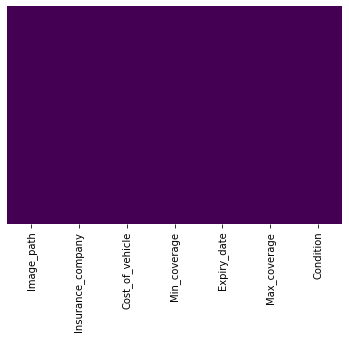

In [32]:
sns.heatmap(test_df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

### Dealing with Missing Values

Since, the dataSet is highly imbalanced, and we cann't fill the missing values with mean(), or median().<br>
So, we drop all the NULL values.
Also, <br>
The majority of the Images are of Damaged cars.<br>
And some of the images can be treated as noise for data

In [33]:
train_df.dropna(inplace = True)

In [34]:
test_df.dropna(inplace = True)

## Encoding Categorical Features

In [35]:
train_df.Insurance_company.value_counts()

B     139
A     126
C     124
BQ    122
BB    117
O     115
BC    115
AA    113
DA    112
AC    110
RE    108
Name: Insurance_company, dtype: int64

In [36]:
test_df.Insurance_company.value_counts()

BB    67
AA    62
A     60
C     60
B     59
RE    54
BQ    52
AC    50
O     50
BC    43
DA    43
Name: Insurance_company, dtype: int64

In [37]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()   

#train
train_df['Insurance_company'] = le.fit_transform(train_df['Insurance_company'])

#test
test_df['Insurance_company'] = le.fit_transform(test_df['Insurance_company'])

### Converting the feature "Expiry_date" into pandas datetime format

In [38]:
#train data

train_df.Expiry_date = train_df.Expiry_date.apply(pd.to_datetime)
train_df['month'] = train_df.Expiry_date.apply(lambda x: x.month)
train_df['day'] = train_df.Expiry_date.apply(lambda x: x.day)
train_df['year'] = train_df.Expiry_date.apply(lambda x: x.year)
train_df.drop(['Expiry_date'], 1, inplace = True)

#test data

test_df.Expiry_date = test_df.Expiry_date.apply(pd.to_datetime)
test_df['month'] = test_df.Expiry_date.apply(lambda x: x.month)
test_df['day'] = test_df.Expiry_date.apply(lambda x: x.day)
test_df['year'] = test_df.Expiry_date.apply(lambda x: x.year)
test_df.drop(['Expiry_date'], 1, inplace = True)



In [39]:
train_df = train_df.drop(['Image_path'], axis = 1)
test_df= test_df.drop(['Image_path'], axis = 1)

In [40]:
train_df = train_df.astype(float)
test_df = test_df.astype(float)

In [41]:
test_df = test_df.drop(['day', 'month', 'year'], axis = 1)

In [42]:
test_df.head()

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition
0,3.0,23600.0,590.0,5978.0,1.0
1,7.0,28300.0,707.5,7153.0,1.0
2,2.0,43700.0,1092.5,11003.0,1.0
3,4.0,46100.0,1152.5,11603.0,1.0
4,4.0,40700.0,1017.5,10253.0,1.0


In [43]:
X = train_df.drop(['Amount', 'day', 'month', 'year'], axis = 1)
y =train_df['Amount']

## Random Forest Regression

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 2000, n_jobs = 1, max_depth=10, random_state = 42)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=2000, n_jobs=1,
                      random_state=42)

In [45]:
prediction = regressor.predict(test_df)

In [46]:
prediction

array([ 4441.71536145,  3520.00418269,  3952.12864159,  4283.47978583,
        4536.31008199,  4223.89571124,  4639.92417788,  2295.88367382,
        5305.65188814,  6603.90170417,  2296.8740874 ,  4639.4145641 ,
        3511.01646079,  5377.16777801,  3970.47991043,  3970.47991043,
        3431.61728022,  4451.08932226,  4201.4980506 ,  3850.5487188 ,
        4270.04346285,  3469.46394276,  4797.84669268,  4079.10853704,
        4296.16312968,  6192.76941985,     0.        ,  5106.02301449,
        4569.84726126,  5661.25943311,  4883.80282074,  3656.42810071,
        3992.74773703,  3162.73849487,  3997.81734389,  4116.84709516,
        2043.23617094,  4483.45296776,  2224.05582231,  4370.0658421 ,
        3771.37211156,  2771.13978425,  4393.60927102,  4679.60924507,
        3974.46055004,  4659.51137316,  2306.48317963,  4629.12802607,
        3703.98570756,  3907.15788839,  3475.00969576,  2148.92394607,
        4702.82119456,  4521.04760225,  5517.66962482,  3716.78772819,
      

### Creating the submission file

In [47]:
test_data = pd.read_csv("test.csv") # For Getting the Image_path feature.

In [48]:
submission = pd.DataFrame({'Image_path': test_data.Image_path, 
                           'Condition': test_df.Condition, 
                           'Amount': prediction})

submission.to_csv('submission.csv', index=False)